In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../..")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import utils.constants as constants

In [4]:
df = pd.read_csv("resources/data/raw/loan.csv")

/tmp/ipykernel_21735/2311671977.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("resources/data/raw/loan.csv")


In [5]:
# Select relevant target values
df = df.loc[
    (df[constants.TARGET_COLUMN] == constants.FULLY_PAID_STATUS) |
    (df[constants.TARGET_COLUMN] == constants.CHARGED_OFF_STATUS)
]
df[constants.TARGET_COLUMN] = df[constants.TARGET_COLUMN].map({
    constants.FULLY_PAID_STATUS: 0,
    constants.CHARGED_OFF_STATUS: 1
})

In [6]:
# Generate report to speed up EDA
# ProfileReport(df, "Initial EDA").to_file("notebooks/eda/profiler.html")

## Columns to drop

In [7]:
# Columns with single constant value
for col in constants.CONSTANT_COLUMNS:
    print(f"{col}: {df[col].nunique()}")

out_prncp: 1
out_prncp_inv: 1
policy_code: 1
annual_inc_joint: 1
dti_joint: 1
verification_status_joint: 1
pymnt_plan: 2


## Columns to impute

In [8]:
# Categorical columns and seems, that it's ok
# to impute separate category for missing
df["emp_length"].fillna("Missing")

0         10+ years
1          < 1 year
2         10+ years
3         10+ years
5           3 years
            ...    
887351    10+ years
887364     < 1 year
887366      2 years
887369    10+ years
887371      Missing
Name: emp_length, Length: 252971, dtype: object

Nulls in mths_since_last_delinq 0.5566645979183384
Nulls in mths_since_last_record 0.8750924018958695
Nulls in mths_since_last_major_derog 0.8120535555458926


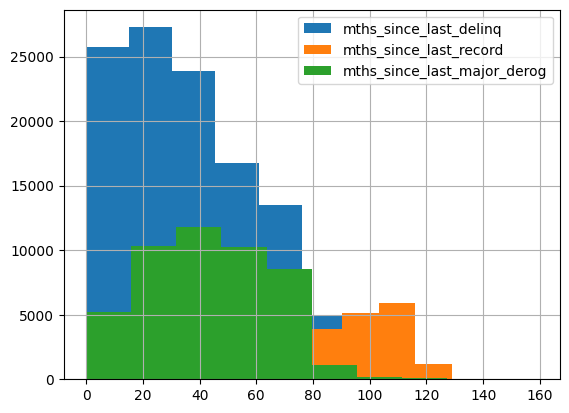

In [9]:
# Column needs categorization and imputation
# "No delinq" 
df["mths_since_last_delinq"].hist()
print(f"Nulls in mths_since_last_delinq {df['mths_since_last_delinq'].isna().mean()}")
df["mths_since_last_record"].hist()
print(f"Nulls in mths_since_last_record {df['mths_since_last_record'].isna().mean()}")
df["mths_since_last_major_derog"].hist()
print(f"Nulls in mths_since_last_major_derog {df['mths_since_last_major_derog'].isna().mean()}")
plt.legend(["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog"])

## Columns that need initial preprocessing

In [10]:
print(df["issue_d"].head(2))
# Need to split into month and year
df["issue_d"].str.split("-", 1, expand=True).rename(columns={0: "month", 1: "year"}).head(2)

0    Dec-2011
1    Dec-2011
Name: issue_d, dtype: object


,month,year
0,Dec,2011
1,Dec,2011


In [11]:
print(df["earliest_cr_line"].head(2))
# Need to split into month and year
df["earliest_cr_line"].str.split("-", 1, expand=True).rename(columns={0: "month", 1: "year"}).head(2)

0    Jan-1985
1    Apr-1999
Name: earliest_cr_line, dtype: object


,month,year
0,Jan,1985
1,Apr,1999


In [12]:
print(df["last_pymnt_d"].head(2))
# Need to split into month and year
df["last_pymnt_d"].str.split("-", 1, expand=True).rename(columns={0: "month", 1: "year"}).head(2)

0    Jan-2015
1    Apr-2013
Name: last_pymnt_d, dtype: object


,month,year
0,Jan,2015
1,Apr,2013


## Propositions for encoding

In [13]:
print(f"Unique values of emp_title: {df['emp_title'].nunique()}")
df.groupby("emp_title").agg({constants.TARGET_COLUMN: "mean"})
# Frequency encoding for emp_title, cause we may want to detect 
# titles, which are more likely to default

Unique values of emp_title: 132761


,loan_status
emp_title,
NSA Industries llc,0.000000
Bus Operator and Instructor,0.000000
Long Ilsand College Hospital,1.000000
BUS OPERATER,0.000000
Golf Sevice Manager/ Caddie Master,0.000000
...,...
zone manager,0.333333
zookeeper,0.000000
zozaya officiating,1.000000


In [14]:
df["total_rev_hi_lim"]

0             NaN
1             NaN
2             NaN
3             NaN
5             NaN
           ...   
887351    20400.0
887364    41700.0
887366     1800.0
887369    30100.0
887371    16800.0
Name: total_rev_hi_lim, Length: 252971, dtype: float64

In [15]:
# Model-based: 
# * tot_coll_amt
# * tot_cur_bal
# * total_rev_hi_lim

## Numerical variables preprocessing

I won't be analyzing mean and standard deviation since all numerical variables will be standardized using z-score scaling. However, I want to analyze skewness of distribution and outliers. Also I will try to propose preprocessing specific to particular variables.

In [16]:
def describe_variable(df, column):
    print(f"Skewness: {df[column].skew()}")
    print(df[column].describe())
    df[column].hist()

Skewness: 0.8347734245098661
count    252971.000000
mean      13562.768855
std        8131.729531
min         500.000000
25%        7200.000000
50%       12000.000000
75%       18250.000000
max       35000.000000
Name: loan_amnt, dtype: float64


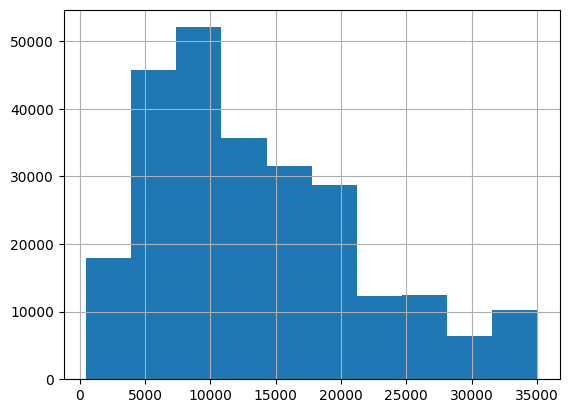

In [17]:
describe_variable(df, "loan_amnt")

* No outliers
* Maybe reduce skewness

Skewness: 0.841665852228792
count    252971.000000
mean      13522.193749
std        8109.211388
min         500.000000
25%        7200.000000
50%       12000.000000
75%       18075.000000
max       35000.000000
Name: funded_amnt, dtype: float64


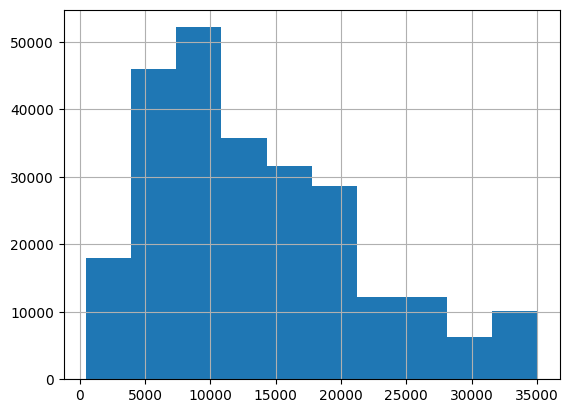

In [18]:
describe_variable(df, "funded_amnt")

Skewness: 0.8405066364579855
count    252971.000000
mean      13429.174497
std        8127.682956
min           0.000000
25%        7200.000000
50%       11975.000000
75%       18000.000000
max       35000.000000
Name: funded_amnt_inv, dtype: float64


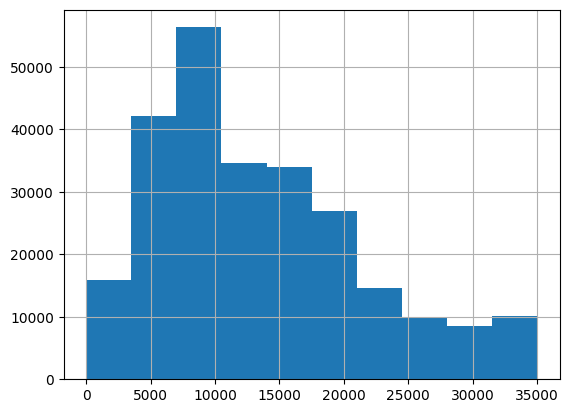

In [19]:
describe_variable(df, "funded_amnt_inv")

Skewness: 0.34610979396257696
count    252971.000000
mean         13.764625
std           4.401926
min           5.320000
25%          10.740000
50%          13.530000
75%          16.550000
max          28.990000
Name: int_rate, dtype: float64


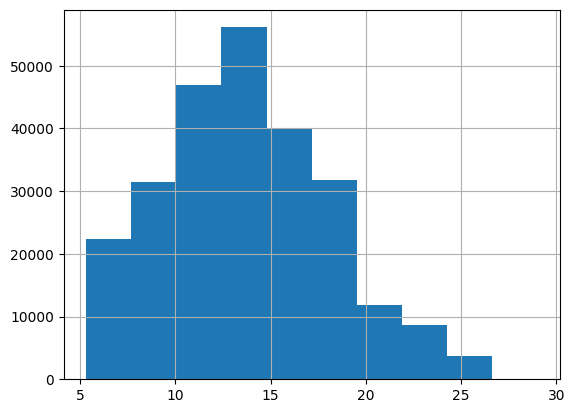

In [20]:
describe_variable(df, "int_rate")

Skewness: 1.0095736058303018
count    252971.000000
mean        418.112216
std         244.933059
min          15.690000
25%         239.550000
50%         365.230000
75%         547.550000
max        1424.570000
Name: installment, dtype: float64


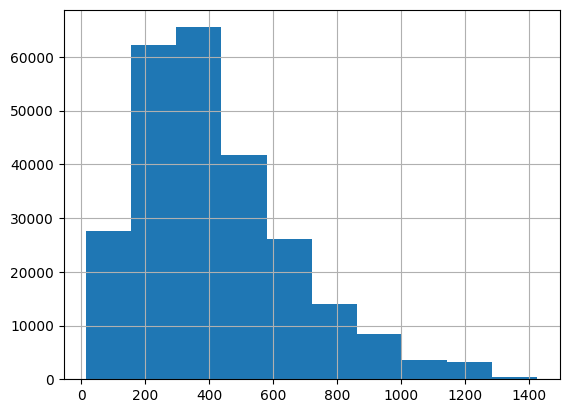

In [21]:
describe_variable(df, "installment")

Skewness: 40.865969364999714
count    2.529710e+05
mean     7.253825e+04
std      5.881181e+04
min      3.000000e+03
25%      4.500000e+04
50%      6.200000e+04
75%      8.700000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64


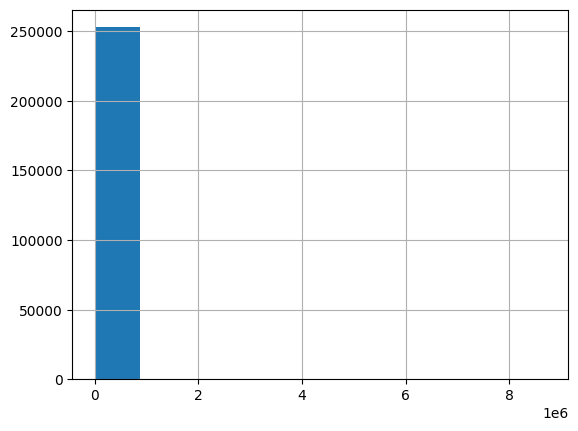

In [22]:
describe_variable(df, "annual_inc")

There is visible outlier. Let's remove it.

In [23]:
import scipy.stats as stats

In [24]:
def get_outliers_thresholds(column, only_positive=False):
    column = column.copy()
    column = column.dropna()
    iqr = stats.iqr(column, nan_policy="raise")
    median = column.median()
    lower_bound = median - 1.5*iqr
    if only_positive:
        lower_bound = max(lower_bound, 0)
    upper_bound = median + 1.5*iqr
    if only_positive:
        upper_bound = max(upper_bound, 0)
    return lower_bound, upper_bound

def cut_outliers(column):
    column = column.copy()
    lower_bound, upper_bound = get_outliers_thresholds(column, only_positive=True)
    column.loc[column < lower_bound] = lower_bound
    column.loc[column > upper_bound] = upper_bound
    return column

Skewness: 40.865969364999714
count    2.529710e+05
mean     7.253825e+04
std      5.881181e+04
min      3.000000e+03
25%      4.500000e+04
50%      6.200000e+04
75%      8.700000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64


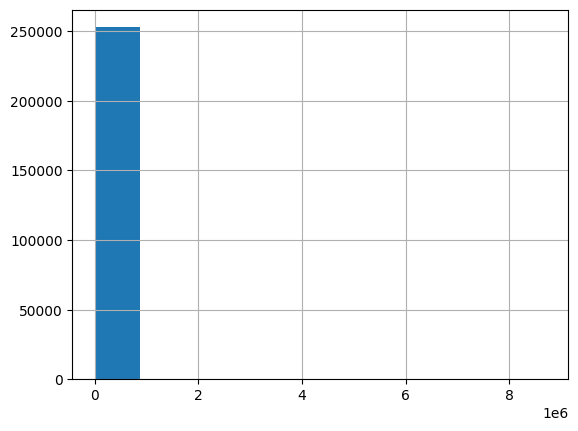

In [25]:
describe_variable(df, "annual_inc")

Skewness: 0.5027594927186039
count    252971.000000
mean      67789.413780
std       29507.243363
min        3000.000000
25%       45000.000000
50%       62000.000000
75%       87000.000000
max      125000.000000
Name: annual_inc_adj, dtype: float64


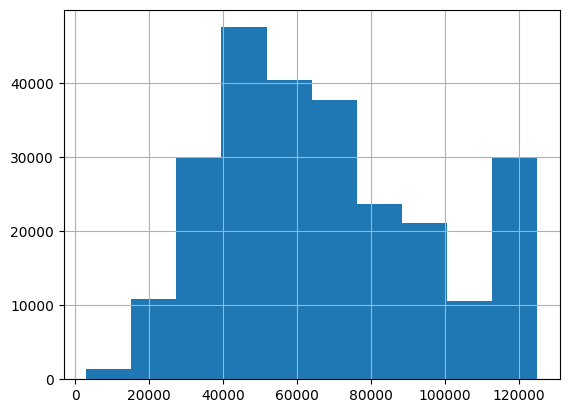

In [26]:
df["annual_inc_adj"] = cut_outliers(df["annual_inc"])
describe_variable(df, "annual_inc_adj")

Skewness: 0.49547178121640184
count    252971.000000
mean         10.774292
std           4.407403
min           0.000000
25%           7.000000
50%          10.000000
75%          14.000000
max          20.500000
Name: open_acc_adj, dtype: float64


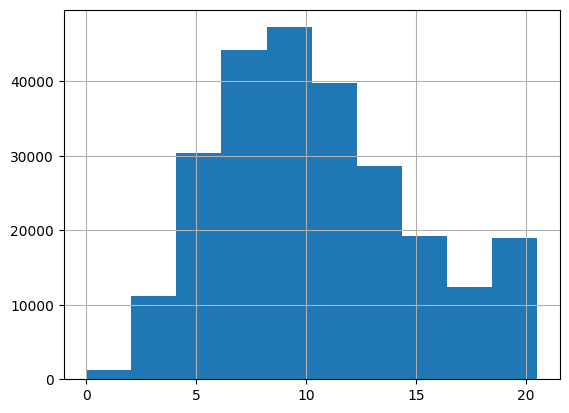

In [27]:
df["open_acc_adj"] = cut_outliers(df["open_acc"])
describe_variable(df, "open_acc_adj")

Skewness: -0.07476949502360669
count    252772.000000
mean         54.312093
std          24.790577
min           0.000000
25%          36.300000
50%          55.800000
75%          73.900000
max         892.300000
Name: revol_util, dtype: float64


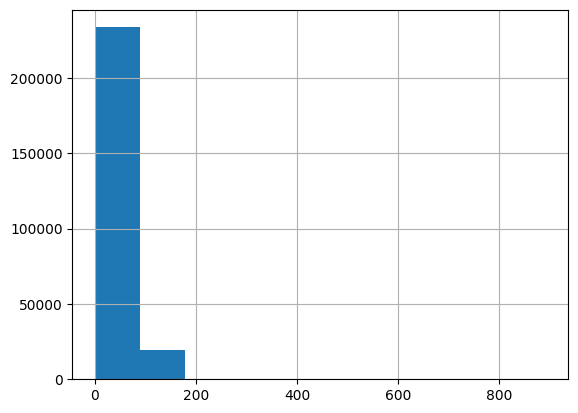

In [28]:
describe_variable(df, "revol_util")

Skewness: -0.22968447214075882
count    252772.000000
mean         54.307939
std          24.731757
min           0.000000
25%          36.300000
50%          55.800000
75%          73.900000
max         112.200000
Name: revol_util_adj, dtype: float64


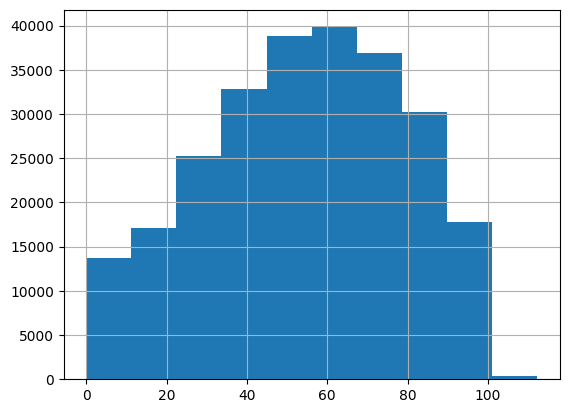

In [29]:
df["revol_util_adj"] = cut_outliers(df["revol_util"])
describe_variable(df, "revol_util_adj")

Skewness: 0.8093303852033387
count    252971.000000
mean         25.035905
std          11.747131
min           2.000000
25%          16.000000
50%          23.000000
75%          32.000000
max         150.000000
Name: total_acc, dtype: float64


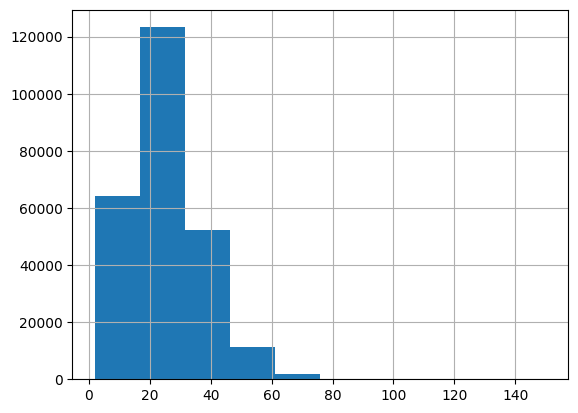

In [30]:
describe_variable(df, "total_acc")

Skewness: 1.0593397126243629
count    252971.000000
mean      13609.603960
std        9483.853558
min           0.000000
25%        6400.055455
50%       11453.600000
75%       18619.100000
max       57777.579870
Name: total_pymnt, dtype: float64


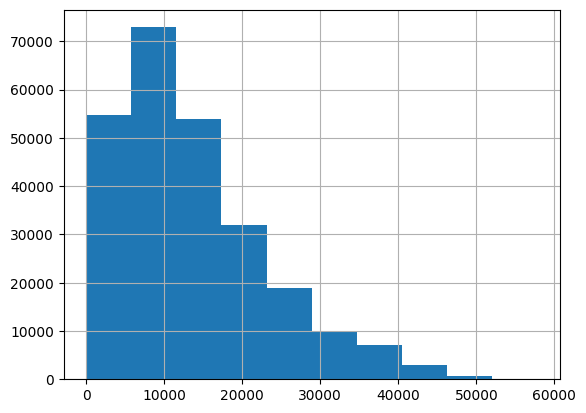

In [31]:
describe_variable(df, "total_pymnt")

Skewness: 1.0600940804174492
count    252971.000000
mean      13511.987257
std        9484.295464
min           0.000000
25%        6307.915000
50%       11364.520000
75%       18503.000000
max       57777.580000
Name: total_pymnt_inv, dtype: float64


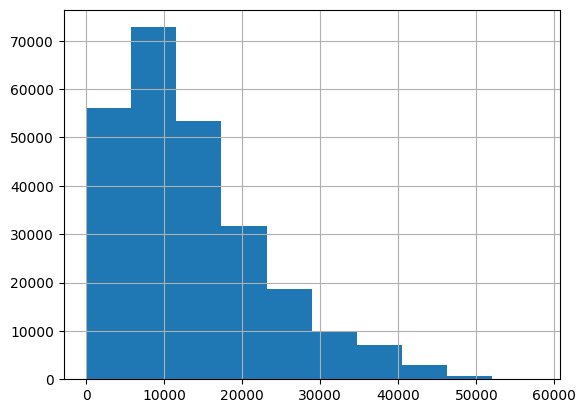

In [32]:
describe_variable(df, "total_pymnt_inv")

Skewness: 0.9137295625351224
count    252971.000000
mean      11502.860871
std        8339.043499
min           0.000000
25%        5000.000000
50%       10000.000000
75%       16000.000000
max       35000.030000
Name: total_rec_prncp, dtype: float64


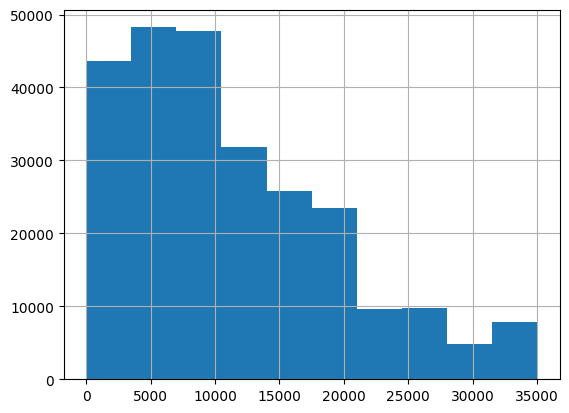

In [33]:
describe_variable(df, "total_rec_prncp")

Skewness: 2.6046069238192593
count    252971.000000
mean       1946.692415
std        2065.498673
min           0.000000
25%         629.545000
50%        1310.220000
75%        2486.145000
max       22777.580000
Name: total_rec_int, dtype: float64


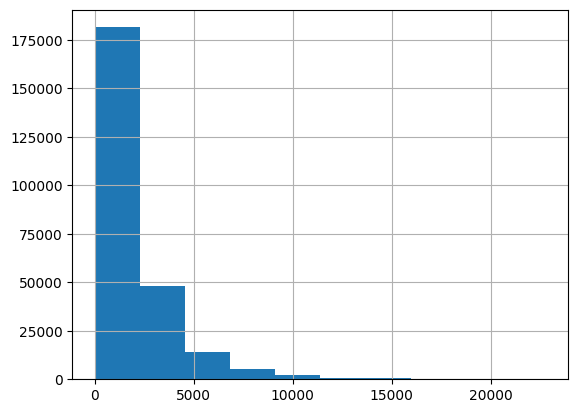

In [34]:
describe_variable(df, "total_rec_int")

Skewness: 1.4380992112713429
count    252971.000000
mean       6461.736176
std        7363.831427
min           0.000000
25%         489.450000
50%        3943.090000
75%       10037.915000
max       36475.590000
Name: last_pymnt_amnt, dtype: float64


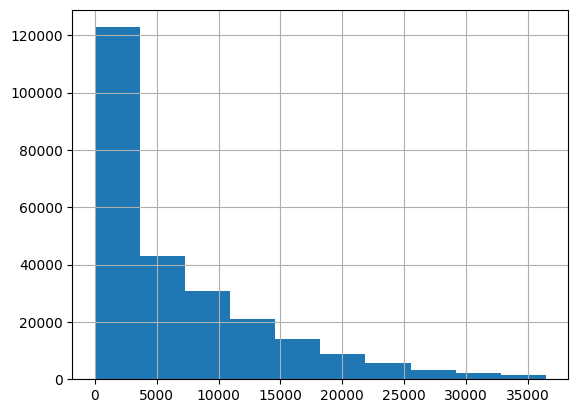

In [35]:
describe_variable(df, "last_pymnt_amnt")

Skewness: 0.22756207888726948
count    47545.000000
mean        43.391734
std         21.620717
min          0.000000
25%         26.000000
50%         43.000000
75%         60.000000
max        159.000000
Name: mths_since_last_major_derog, dtype: float64


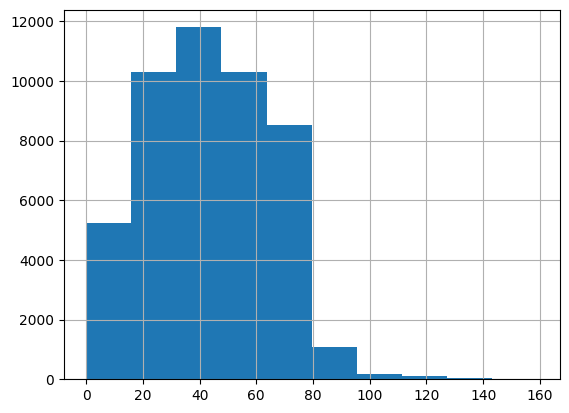

In [36]:
describe_variable(df, "mths_since_last_major_derog")

In [37]:
df["all_util"]

0        NaN
1        NaN
2        NaN
3        NaN
5        NaN
          ..
887351   NaN
887364   NaN
887366   NaN
887369   NaN
887371   NaN
Name: all_util, Length: 252971, dtype: float64

In [38]:
for column in constants.COLUMNS_TO_REDUCE_SKEWNESS:
    print(f"Skewness of {column}: {df[column].skew()}")

Skewness of loan_amnt: 0.8347734245098661
Skewness of funded_amnt: 0.841665852228792
Skewness of installment: 1.0095736058303018
Skewness of total_acc: 0.8093303852033387
Skewness of total_pymnt: 1.0593397126243629
Skewness of total_pymnt_inv: 1.0600940804174492
Skewness of total_rec_prncp: 0.9137295625351224
Skewness of total_rec_int: 2.6046069238192593
Skewness of last_pymnt_amnt: 1.4380992112713429
Skewness of mths_since_last_major_derog: 0.22756207888726948
Skewness of tot_coll_amt: 431.1103811619829
Skewness of tot_cur_bal: 3.390980660583196
Skewness of total_rev_hi_lim: 8.273318451346206
